# Testing Facenet for Bias in Facial Recognition
### By Rufaida Khan, Julissa Mota, and Gazi Rahman

### Loading modules
Among our modules...
- `facenet_pytorch` contains our models for face detection, cropping, and embedding
- `PIL` contains tools for Image processing
- `pandas` offers resources for data analysis
- `os` will allow us to walk through the dataset
- `tqdm` enables us to create loading bars
- `sklearn` will illustrate our results
- `scipy` has tools to conduct chi-square tests

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

### Preparing the Data


In [2]:
data_path = '/Users/gazirahman/coursework/comp334/project/algorithmic_bias/CFD'
model_dirs = sorted(os.listdir(data_path))
model_id = []
img_id = []
race = []
sex = []
for dir_name in model_dirs:
    if dir_name == '.DS_Store' or dir_name == 'Icon\r':
        continue
    img_list = os.listdir(f"{data_path}/{dir_name}")
    for img_name in img_list:
        if img_name == '.DS_Store' or img_name == 'Icon\r':
            continue
        model_id.append(dir_name)
        img_id.append(img_name)
        attributes = img_name.split('-')
        race.append(attributes[1][0])
        sex.append(attributes[1][1])
race = ['Asian' if label == 'A' else 'Black' if label == 'B' else 'Latino' if label == 'L' else 'White' for label in race]
sex = ['Female' if label == 'F' else 'Male' for label in sex ]
df = pd.DataFrame({'model_id': model_id, 'img_id': img_id, 'race': race, 'sex': sex})
display(df)

,model_id,img_id,race,sex
0,AF-200,CFD-AF-200-228-N.jpg,Asian,Female
1,AF-201,CFD-AF-201-060-N.jpg,Asian,Female
2,AF-202,CFD-AF-202-122-N.jpg,Asian,Female
3,AF-203,CFD-AF-203-077-N.jpg,Asian,Female
4,AF-204,CFD-AF-204-067-N.jpg,Asian,Female
...,...,...,...,...
1202,WM-254,CFD-WM-254-152-N.jpg,White,Male
1203,WM-255,CFD-WM-255-219-N.jpg,White,Male
1204,WM-256,CFD-WM-256-138-N.jpg,White,Male
1205,WM-257,CFD-WM-257-161-N.jpg,White,Male


In [3]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
mtcnn = MTCNN()

def get_embedding(image_path):
    img = Image.open(image_path)
    aligned = mtcnn(img)
    if aligned is not None:
        aligned = aligned.unsqueeze(0)
        embedding = resnet(aligned).detach().numpy() 
        return embedding
    return None

embeddings = {}
for i in tqdm(range(len(df)), desc="Computing embeddings"):
    img_path = f"{data_path}/{df.iloc[i]['model_id']}/{df.iloc[i]['img_id']}"
    embeddings[i] = get_embedding(img_path)

Computing embeddings: 100%|██████████| 1207/1207 [07:23<00:00,  2.72it/s]


In [4]:
model1, model2 = [], []
img1, img2 = [], []
race1, race2 = [], []
sex1, sex2 = [], []
distance, label, prediction = [], [], []

# Convert DataFrame to NumPy array for faster access
df_array = df.to_numpy()

# Process pairs
for i in tqdm(range(len(df)), desc="Processing image pairs"):
    for j in range(i+1, len(df)):
        embedding1 = embeddings[i]
        embedding2 = embeddings[j]

        if embedding1 is not None and embedding2 is not None:
            dist = np.linalg.norm(embedding1 - embedding2)
            pred = dist < 1.0

            model1.append(df_array[i, 0])
            model2.append(df_array[j, 0])
            img1.append(df_array[i, 1])
            img2.append(df_array[j, 1])
            race1.append(df_array[i, 2])
            race2.append(df_array[j, 2])
            sex1.append(df_array[i, 3])
            sex2.append(df_array[j, 3])
            distance.append(dist)
            label.append(df_array[i, 0] == df_array[j, 0])
            prediction.append(pred)

Processing image pairs: 100%|██████████| 1207/1207 [00:02<00:00, 571.55it/s]


In [5]:
results = pd.DataFrame({'model1': model1, 'model2': model2, 'img1': img1, 'img2': img2, 'race1': race1, 'race2': race2, 'sex1': sex1, 'sex2': sex2, 'distance': distance, 'label': label, 'prediction': prediction})
len(results)

727821

In [6]:
results.loc[(results['label'] == True) & (results['prediction'] == False)]

,model1,model2,img1,img2,race1,race2,sex1,sex2,distance,label,prediction
721382,WM-029,WM-029,CFD-WM-029-014-A.jpg,CFD-WM-029-029-HO.jpg,White,White,Male,Male,1.029265,True,False


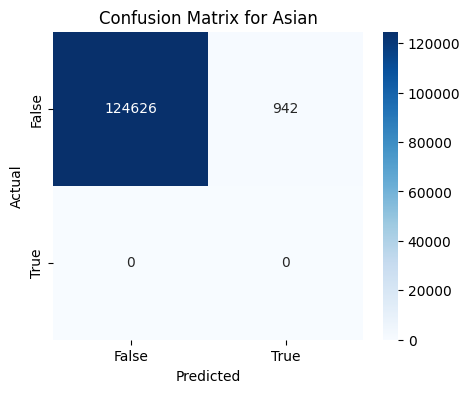

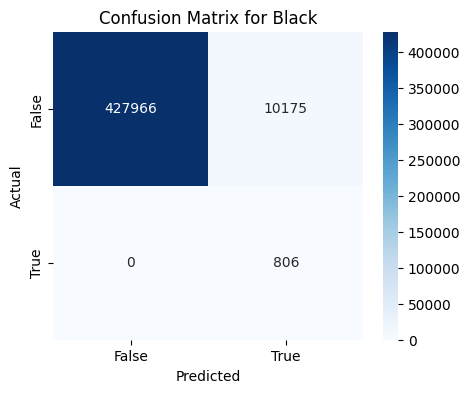

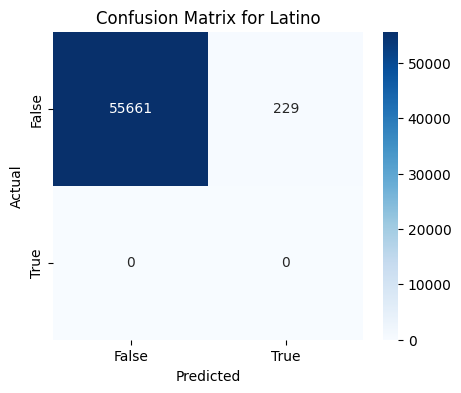

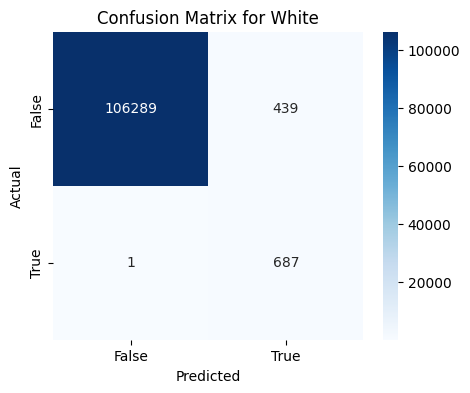

Accuracy for Asian: 0.9924980886850153
Accuracy for Black: 0.9768195249084741
Accuracy for Latino: 0.9959026659509751
Accuracy for White: 0.9959037759737842
Chi-square test statistic: 4816.006255555913, p-value: 0.0


In [7]:
races = results['race1'].unique()
accuracy_by_race = {}
confusion_matrices = {}
for race in races:
    race_results = results[results['race1'] == race]
    cm = confusion_matrix(race_results['label'], race_results['prediction'])
    accuracy = accuracy_score(race_results['label'], race_results['prediction'])
    accuracy_by_race[race] = accuracy
    confusion_matrices[race] = cm

    # Plot heatmap for each race
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.title(f'Confusion Matrix for {race}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Print accuracy for each race
for race, accuracy in accuracy_by_race.items():
    print(f"Accuracy for {race}: {accuracy}")

# Perform statistical test (Chi-square test) to check for variation in accuracy
# Create a contingency table
contingency_table = np.array([confusion_matrices[race].ravel() for race in races])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test statistic: {chi2}, p-value: {p}")

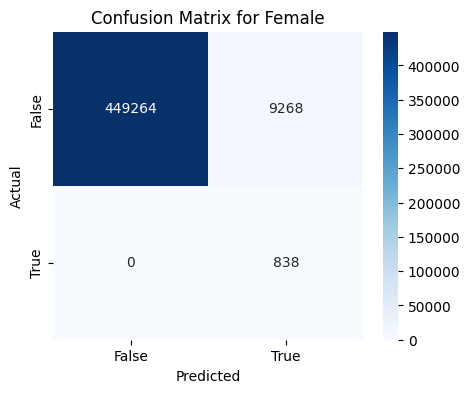

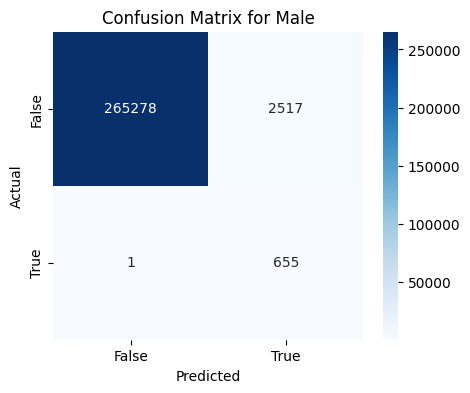

Accuracy for Female: 0.9798245423079435
Accuracy for Male: 0.9906202621707499
Chi-square test statistic: 1271.3033014947239, p-value: 2.4797136236243884e-275


In [8]:
sexes = results['sex1'].unique()
accuracy_by_sex = {}
confusion_matrices = {}
for sex in sexes:
    sex_results = results[results['sex1'] == sex]
    cm = confusion_matrix(sex_results['label'], sex_results['prediction'])
    accuracy = accuracy_score(sex_results['label'], sex_results['prediction'])
    accuracy_by_sex[sex] = accuracy
    confusion_matrices[sex] = cm

    # Plot heatmap for each race
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.title(f'Confusion Matrix for {sex}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Print accuracy for each race
for sex, accuracy in accuracy_by_sex.items():
    print(f"Accuracy for {sex}: {accuracy}")

# Perform statistical test (Chi-square test) to check for variation in accuracy
# Create a contingency table
contingency_table = np.array([confusion_matrices[sex].ravel() for sex in sexes])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test statistic: {chi2}, p-value: {p}")

In [9]:
results['false_positive'] = ((results['label'] == False) & (results['prediction'] == True)).astype(int)
results['false_negative'] = ((results['label'] == True) & (results['prediction'] == False)).astype(int)

In [10]:
results

,model1,model2,img1,img2,race1,race2,sex1,sex2,distance,label,prediction,false_positive,false_negative
0,AF-200,AF-201,CFD-AF-200-228-N.jpg,CFD-AF-201-060-N.jpg,Asian,Asian,Female,Female,0.942857,False,True,1,0
1,AF-200,AF-202,CFD-AF-200-228-N.jpg,CFD-AF-202-122-N.jpg,Asian,Asian,Female,Female,1.093097,False,False,0,0
2,AF-200,AF-203,CFD-AF-200-228-N.jpg,CFD-AF-203-077-N.jpg,Asian,Asian,Female,Female,0.993883,False,True,1,0
3,AF-200,AF-204,CFD-AF-200-228-N.jpg,CFD-AF-204-067-N.jpg,Asian,Asian,Female,Female,1.123268,False,False,0,0
4,AF-200,AF-205,CFD-AF-200-228-N.jpg,CFD-AF-205-155-N.jpg,Asian,Asian,Female,Female,0.964304,False,True,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
727816,WM-255,WM-257,CFD-WM-255-219-N.jpg,CFD-WM-257-161-N.jpg,White,White,Male,Male,1.071999,False,False,0,0
727817,WM-255,WM-258,CFD-WM-255-219-N.jpg,CFD-WM-258-125-N.jpg,White,White,Male,Male,1.385476,False,False,0,0
727818,WM-256,WM-257,CFD-WM-256-138-N.jpg,CFD-WM-257-161-N.jpg,White,White,Male,Male,1.274524,False,False,0,0
727819,WM-256,WM-258,CFD-WM-256-138-N.jpg,CFD-WM-258-125-N.jpg,White,White,Male,Male,1.544425,False,False,0,0


In [11]:
model_fp = ols('false_positive ~ C(race1)', data=results).fit()
anova_table_fp = sm.stats.anova_lm(model_fp, typ=2)
print("ANOVA for False Positives:")
# print(anova_table_fp)
print(model_fp.summary())

ANOVA for False Positives:
                            OLS Regression Results                            
Dep. Variable:         false_positive   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1153.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        09:09:02   Log-Likelihood:             4.7542e+05
No. Observations:              727821   AIC:                        -9.508e+05
Df Residuals:                  727817   BIC:                        -9.508e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept

In [12]:
model_fn = ols('false_negative ~ C(race1)', data=results).fit()
anova_table_fn = sm.stats.anova_lm(model_fn, typ=2)
print("ANOVA for False Negatives:")
# print(anova_table_fn)
print(model_fn.summary())

ANOVA for False Negatives:
                            OLS Regression Results                            
Dep. Variable:         false_negative   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.925
Date:                Mon, 02 Dec 2024   Prob (F-statistic):              0.123
Time:                        09:09:04   Log-Likelihood:             3.8793e+06
No. Observations:              727821   AIC:                        -7.759e+06
Df Residuals:                  727817   BIC:                        -7.758e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept